In [34]:
# Set the working directory
import os
os.getcwd()
os.chdir('/home/shoyo/Desktop')
# os.listdir( os.getcwd() )

In [35]:
# Import modules
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# !pip install geopandas --quiet
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
import scipy
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
# !pip install rasterio --quiet
import rasterio
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import math
from datetime import datetime
import joblib
import shap

In [36]:
# Set seed
def set_seed(seed: int = 42) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [37]:
# Load the csv file
csv_path = os.getcwd() + '/SOC6m3119.csv'
df1 = pd.read_csv(csv_path)
df2 = df1[ (df1.EVI<-2) | (df1.EVI>2) ]

df = pd.DataFrame(columns=df1.columns)
for i in range(len(df1)):
    lat = df1.loc[i, 'latitude']
    lon = df1.loc[i, 'longitude']
    if not ((df2['latitude'] == lat) & (df2['longitude'] == lon)).any():
        # df = pd.concat([df, df1.loc[i]]) 
        df.loc[len(df)] = df1.iloc[i]
        # df = df.append(df1.loc[i]) 

df['temp'] = df['temp']*0.02
df = df.drop(columns=['latitude', 'longitude', 'year', 'LC', 'site', 'siteid'])
df

,SOC,elev,slope,aspect,roughness,twi,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,EVI,VV,VH,VV/VH,prec,temp
0,18.08215,733,14.546583,6.157959,33.428909,-2.764669,0.495186,0.50455,0.508799,0.619528,0.421844,0.302109,0.249578,0.076579,0.020804,3.680936,18.45042,299.087895
1,18.08215,733,14.546583,6.157959,33.428909,-2.764669,0.613395,0.590047,0.607551,0.644841,0.527856,0.41699,0.130808,0.055299,0.009868,5.604137,12.463107,303.8782
2,18.08215,733,14.546583,6.157959,33.428909,-2.764669,0.514794,0.547574,0.553665,0.657051,0.36925,0.229632,0.677022,0.086492,0.016536,5.230641,15.063257,299.177303
3,18.08215,733,14.546583,6.157959,33.428909,-2.764669,0.540919,0.547203,0.565229,0.665329,0.528585,0.450788,0.214224,0.097643,0.016181,6.034561,15.205925,302.826742
4,8.9793,1071,19.300432,22.724434,49.945877,-2.874085,0.016301,0.061058,0.062419,0.216707,0.145029,0.096973,0.240661,0.183756,0.058889,3.120377,15.831832,305.77443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12435,8.04395,202,2.780292,98.300659,1.328088,0.017878,0.314814,0.350633,0.369993,0.53733,0.409056,0.296911,0.302399,0.235468,0.073275,3.213477,10.421789,303.051429
12436,7.548,1064,2.074803,253.801025,1.301188,0.200059,0.042935,0.09051,0.129367,0.229412,0.177712,0.159315,0.116971,0.017431,0.002679,6.505904,5.778829,315.733571
12437,7.548,1064,2.074803,253.801025,1.301188,0.200059,0.24198,0.281662,0.31645,0.372358,0.359886,0.312889,0.054294,0.016506,0.002907,5.678041,3.777829,314.70129
12438,7.548,1064,2.074803,253.801025,1.301188,0.200059,0.162642,0.204951,0.247645,0.303113,0.313219,0.267266,0.067999,0.01521,0.003347,4.544754,0.03365,311.041622


In [38]:
array = list(range(3111))
# random.shuffle(array)
np.random.seed(42)
np.random.shuffle(array)

# Create a new column to group rows into blocks of 5
df['Group'] = (df.index // 4) + 1

dataframe = pd.DataFrame(columns=df.columns)
for idx in array:
    dataframe = pd.concat([dataframe, df[df['Group']==idx]])
dataframe = dataframe.drop('Group', axis=1)
df = dataframe

In [39]:
newdf = df.drop(columns=['SOC', 'elev', 'slope', 'aspect', 'roughness', 'twi'])
newdf = pd.DataFrame(newdf.values.reshape(int(12440/4), 12*4))
adddf = df[['SOC', 'elev', 'slope', 'aspect', 'roughness', 'twi']][::4].reset_index(drop=True)
newdf = pd.concat([adddf,newdf], axis=1, ignore_index=True)
newdf.columns = ['SOC', 'elev', 'slope', 'aspect', 'roughness', 'twi', 
'SR_B2-3', 'SR_B3-3', 'SR_B4-3', 'SR_B5-3', 'SR_B6-3', 'SR_B7-3', 'EVI-3', 'VV-3', 'VH-3', 'VV/VH-3', 'prec-3', 'temp-3',
'SR_B2-2', 'SR_B3-2', 'SR_B4-2', 'SR_B5-2', 'SR_B6-2', 'SR_B7-2', 'EVI-2', 'VV-2', 'VH-2', 'VV/VH-2', 'prec-2', 'temp-2',
'SR_B2-1', 'SR_B3-1', 'SR_B4-1', 'SR_B5-1', 'SR_B6-1', 'SR_B7-1', 'EVI-1', 'VV-1', 'VH-1', 'VV/VH-1', 'prec-1', 'temp-1',
'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'EVI', 'VV', 'VH', 'VV/VH', 'prec', 'temp',
    ]
df = newdf

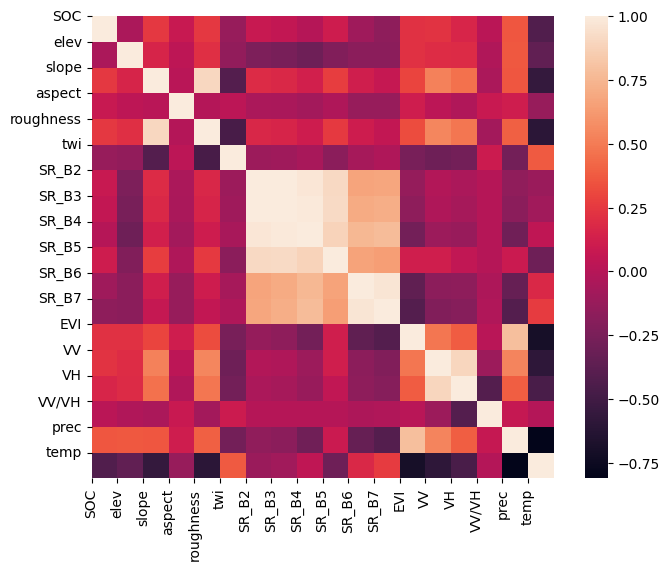

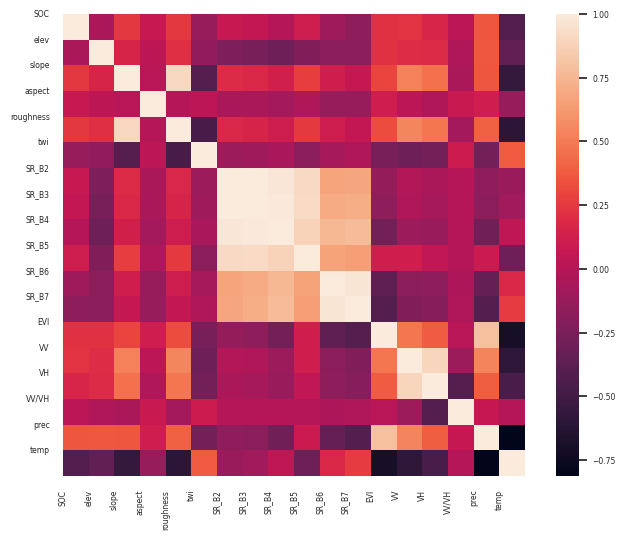

,SOC,elev,slope,aspect,roughness,twi,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,EVI,VV,VH,VV/VH,prec,temp
SOC,1.000000,-0.044999,0.249138,0.074870,0.242877,-0.130771,0.075666,0.058377,-0.002029,0.101205,-0.094484,-0.162197,0.220898,0.225143,0.164342,0.019788,0.358251,-0.424764
elev,-0.044999,1.000000,0.151029,0.033230,0.209943,-0.149984,-0.234416,-0.259574,-0.298324,-0.221172,-0.178248,-0.177760,0.219957,0.193240,0.188842,-0.020661,0.366964,-0.353148
slope,0.249138,0.151029,1.000000,0.011880,0.902544,-0.410558,0.186201,0.174981,0.125031,0.265681,0.116048,0.070019,0.297753,0.524596,0.458201,-0.046616,0.361619,-0.559439
aspect,0.074870,0.033230,0.011880,1.000000,-0.009778,0.024440,-0.045002,-0.051239,-0.077926,-0.026790,-0.125535,-0.125882,0.114191,0.024996,-0.020356,0.083762,0.113601,-0.127345
roughness,0.242877,0.209943,0.902544,-0.009778,1.000000,-0.470625,0.169644,0.155675,0.101714,0.254554,0.103262,0.055669,0.325853,0.541362,0.480687,-0.079316,0.396055,-0.600992
twi,-0.130771,-0.149984,-0.410558,0.024440,-0.470625,1.000000,-0.105161,-0.093845,-0.057861,-0.180170,-0.067461,-0.027807,-0.254020,-0.300412,-0.277672,0.097353,-0.278002,0.374624
SR_B2,0.075666,-0.234416,0.186201,-0.045002,0.169644,-0.105161,1.000000,0.993649,0.975930,0.911510,0.667672,0.679049,-0.138312,-0.016386,-0.046366,-0.001332,-0.154165,-0.117416
SR_B3,0.058377,-0.259574,0.174981,-0.051239,0.155675,-0.093845,0.993649,1.000000,0.988014,0.920036,0.699699,0.712704,-0.164962,-0.032908,-0.062386,0.001572,-0.181131,-0.085793
SR_B4,-0.002029,-0.298324,0.125031,-0.077926,0.101714,-0.057861,0.975930,0.988014,1.000000,0.883504,0.755639,0.776939,-0.274059,-0.108272,-0.121872,-0.002938,-0.294463,0.040004
SR_B5,0.101205,-0.221172,0.265681,-0.026790,0.254554,-0.180170,0.911510,0.920036,0.883504,1.000000,0.661215,0.640938,0.117541,0.115779,0.045396,0.000803,0.089965,-0.299161


In [40]:
averageshap = np.ones((len(df),18))
averageshap[:,:6] = np.array(df)[:,:6]
for i in range(6, 18):
    averageshap[:,i] = np.mean(np.array(df)[:, i::12], axis=1)

variables = ['SOC', 'elev', 'slope', 'aspect', 'roughness', 'twi', 'SR_B2', 'SR_B3',
       'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'EVI', 'VV', 'VH', 'VV/VH', 'prec',
       'temp']

corrmat = pd.DataFrame(averageshap, columns=variables).corr()
sns.heatmap(corrmat, square=True)
sns.set(font_scale=0.5)
plt.xticks(range(len(corrmat.columns)), corrmat.columns, rotation=90)
plt.yticks(range(len(corrmat.index)), corrmat.index, rotation=0)
plt.show()
corrmat

corrmat = pd.DataFrame(averageshap, columns=variables).corr()
sns.heatmap(corrmat, square=True)
sns.set(font_scale=0.5)
plt.xticks(range(len(corrmat.columns)), corrmat.columns, rotation=90)
plt.yticks(range(len(corrmat.index)), corrmat.index, rotation=0)
plt.show()
corrmat

In [56]:
sns.heatmap(corrmat.iloc[:,0].values)

IndexError: Inconsistent shape between the condition and the input (got (18, 1) and (18,))

In [48]:
sns.heatmap(corrmat.iloc[:,0], square=True)
sns.set(font_scale=0.5)
plt.xticks(range(1), corrmat.iloc[0,0].columns, rotation=90)
plt.yticks(range(len(corrmat.iloc[:,0].index)), corrmat.iloc[:,0].index, rotation=0)
plt.show()

IndexError: Inconsistent shape between the condition and the input (got (18, 1) and (18,))

In [22]:
# Shuffle the data
# df = df.sample(frac=1, random_state=42)

# Split the dataset into training, validation and test datasets
n = len(df)

# scaler = MinMaxScaler()
# train_df = scaler.fit_transform(df[0:int(n*0.8)])
# val_df = scaler.fit_transform(df[int(n*0.8):int(n*0.9)])
# test_df = scaler.fit_transform(df[int(n*0.9):])
# Xtrain = train_df[:,1:]
# Ytrain = train_df[:,0]
# Xval = val_df[:,1:]
# Yval = val_df[:,0]
# Xtest = test_df[:,1:]
# Ytest = test_df[:,0]

# train_df = df[0:int(n*0.8)]
# val_df = df[int(n*0.8):int(n*0.9)]
# test_df = df[int(n*0.9):]
train_df = df[:2488]
val_df = df[2488:(2488+311)]
test_df = df[(2488+311):]
Xtrain = train_df.iloc[:,1:]
Ytrain = train_df.iloc[:,0]
Xval = val_df.iloc[:,1:]
Yval = val_df.iloc[:,0]
Xtest = test_df.iloc[:,1:]
Ytest = test_df.iloc[:,0]

# train_df = scaler.fit_transform(df[:11760])
# val_df = scaler.fit_transform(df[11760:(11760+1464)])
# test_df = scaler.fit_transform(df[(11760+1464):])

In [40]:
# Show metadata of the dataset
df.apply(['mean', 'median', 'max', 'min', 'std', 'skew', 'count']).transpose()

,mean,median,max,min,std,skew,count
SOC,10.833625,8.066600,119.511800,1.612800,10.504120,3.934853,3110.0
elev,834.919936,945.500000,2022.000000,-3.000000,499.982959,-0.222621,3110.0
slope,5.135545,2.930427,44.899754,0.000000,6.797008,2.765509,3110.0
aspect,167.911017,159.812782,359.977112,0.032219,106.987042,0.190670,3110.0
roughness,15.927020,5.875148,201.859283,0.215358,26.917757,2.876610,3110.0
twi,0.367423,0.057538,10.531526,-3.988649,2.112157,1.142651,3110.0
SR_B2-3,0.248570,0.171188,1.182233,-0.091829,0.218902,0.852904,3110.0
SR_B3-3,0.285737,0.217333,1.122640,-0.024014,0.191143,0.845750,3110.0
SR_B4-3,0.298027,0.232589,1.151542,-0.021992,0.191648,0.798903,3110.0
SR_B5-3,0.423350,0.397135,1.152450,0.064564,0.154722,0.573826,3110.0


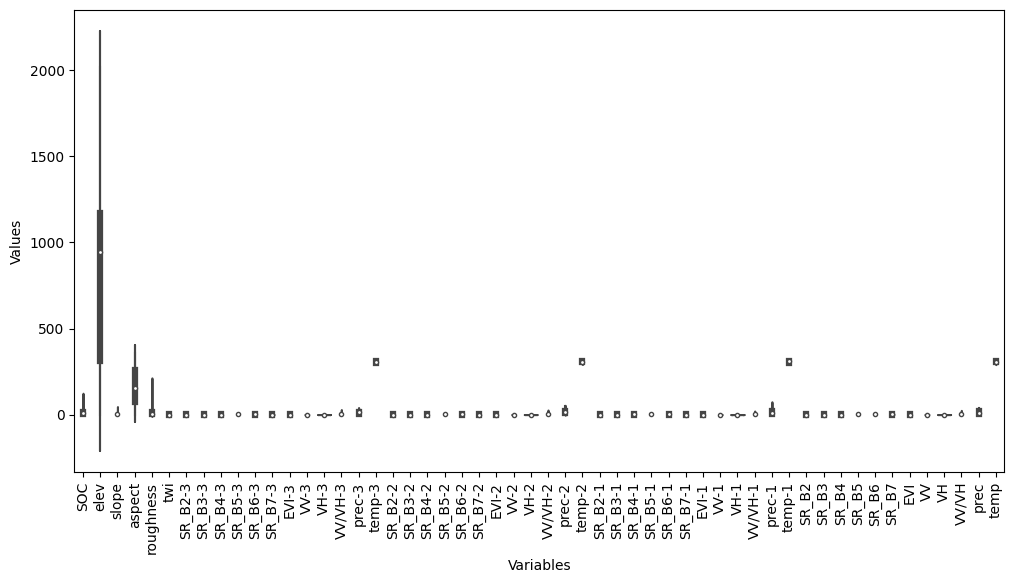

In [41]:
# Show the data ranges of the dataset
# df_std = pd.DataFrame(train_df).melt(var_name='Variables', value_name='Values')
df_std = train_df.melt(var_name='Variables', value_name='Values')
df_std['Values'] = pd.to_numeric(df_std['Values'], errors='coerce')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Variables', y='Values', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [23]:
# Set grid search parameters
n_trees_range = [10, 50, 100, 200, 300, 400, 500, 600]
min_samples_range = [2, 5, 10, 15, 20, 25, 30]

# prepare matrix for storing the matrics reached on the validation set per parameter combination
rmse_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])
mae_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])
rsquare_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])
oob_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])
time_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])

# Perform the parameter searching and keep track of performance
for n_trees_index, n_trees in enumerate(n_trees_range):
    for min_leaves_index, min_samples in enumerate(min_samples_range):
        print(f"N trees: {n_trees}, Min. samples samples per leaf: {min_samples}")
        
        # Initialize the random forest classifier
        model = RandomForestRegressor(n_estimators=n_trees, min_samples_split=min_samples, oob_score=True, random_state=42)
        
        # Fit the classifier to the training data/labels
        start = datetime.now()
        model.fit(Xtrain, Ytrain)
        end = datetime.now()
        time_taken = float(f"{(end - start).seconds}.{round((end - start).microseconds, 2)}")

        # Use the model to predict all of the validation pixels
        predictions = model.predict(Xval)

        # Calculate the accuracy of the predicted labels vs the ground truth labels
        rmse = math.sqrt( mean_squared_error(predictions, Yval) )
        mae = mean_absolute_error(predictions, Yval)
        rsquared = r2_score(predictions, Yval)
        oob = model.oob_score_

        # Store accuracies and time taken for this parameter combination
        rmse_paramsearch[n_trees_index, min_leaves_index] = round(rmse, 2)
        mae_paramsearch[n_trees_index, min_leaves_index] = round(mae, 2)
        rsquare_paramsearch[n_trees_index, min_leaves_index] = round(rsquared, 2)
        oob_paramsearch[n_trees_index, min_leaves_index] = round(oob, 2)
        time_paramsearch[n_trees_index, min_leaves_index] = round(time_taken, 2)

N trees: 10, Min. samples samples per leaf: 2


Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


N trees: 10, Min. samples samples per leaf: 5


Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


N trees: 10, Min. samples samples per leaf: 10


Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


N trees: 10, Min. samples samples per leaf: 15


Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


N trees: 10, Min. samples samples per leaf: 20


Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


N trees: 10, Min. samples samples per leaf: 25


Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


N trees: 10, Min. samples samples per leaf: 30


Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


N trees: 50, Min. samples samples per leaf: 2
N trees: 50, Min. samples samples per leaf: 5
N trees: 50, Min. samples samples per leaf: 10
N trees: 50, Min. samples samples per leaf: 15
N trees: 50, Min. samples samples per leaf: 20
N trees: 50, Min. samples samples per leaf: 25
N trees: 50, Min. samples samples per leaf: 30
N trees: 100, Min. samples samples per leaf: 2
N trees: 100, Min. samples samples per leaf: 5
N trees: 100, Min. samples samples per leaf: 10
N trees: 100, Min. samples samples per leaf: 15
N trees: 100, Min. samples samples per leaf: 20
N trees: 100, Min. samples samples per leaf: 25
N trees: 100, Min. samples samples per leaf: 30
N trees: 200, Min. samples samples per leaf: 2
N trees: 200, Min. samples samples per leaf: 5
N trees: 200, Min. samples samples per leaf: 10
N trees: 200, Min. samples samples per leaf: 15
N trees: 200, Min. samples samples per leaf: 20
N trees: 200, Min. samples samples per leaf: 25
N trees: 200, Min. samples samples per leaf: 30
N tre

KeyboardInterrupt: 

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


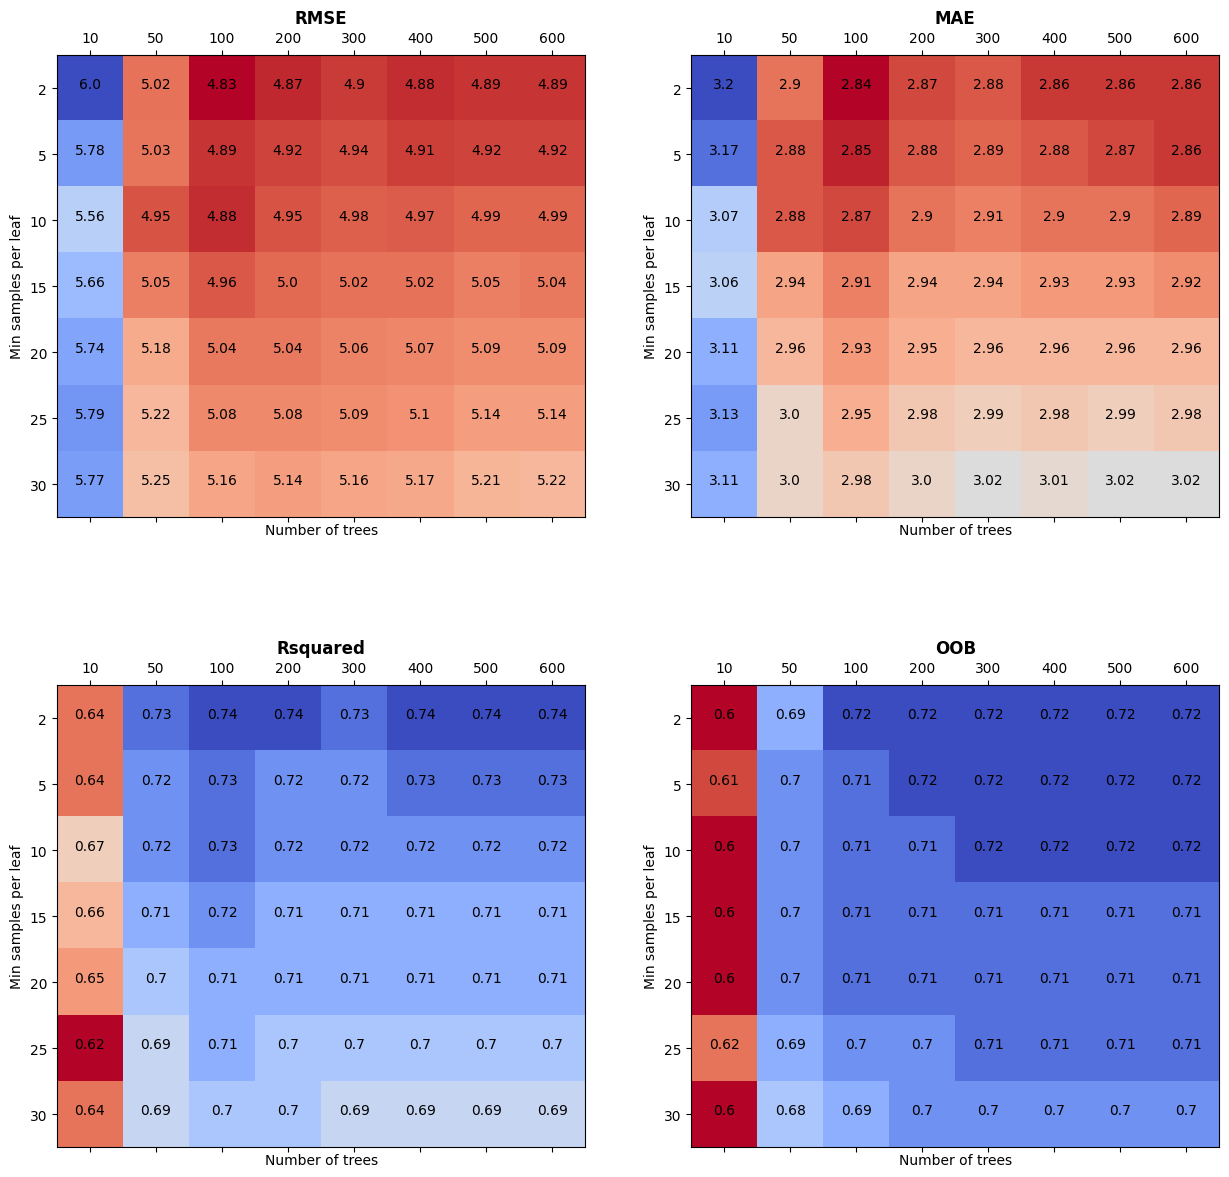

In [43]:
# Plot the validation results
n_trees_labels = [0] + n_trees_range
min_leaves_labels = [0] + min_samples_range 

fig, ((ax_rmse, ax_mae), (ax_rsquared, ax_oob)) = plt.subplots(2, 2, figsize=(15,15))

## Plot RMSE
ax_rmse.set_title("RMSE", weight='bold')
ax_rmse.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_rmse.set_xticklabels(n_trees_labels)
ax_rmse.set_yticklabels(min_leaves_labels)
ax_rmse.matshow(rmse_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Plot MAE
ax_mae.set_title("MAE", weight='bold')
ax_mae.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_mae.set_xticklabels(n_trees_labels)
ax_mae.set_yticklabels(min_leaves_labels)
ax_mae.matshow(mae_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Plot Rsquared
ax_rsquared.set_title("Rsquared", weight='bold')
ax_rsquared.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_rsquared.set_xticklabels(n_trees_labels)
ax_rsquared.set_yticklabels(min_leaves_labels)
ax_rsquared.matshow(rsquare_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Plot oob
ax_oob.set_title("OOB", weight='bold')
ax_oob.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_oob.set_xticklabels(n_trees_labels)
ax_oob.set_yticklabels(min_leaves_labels)
ax_oob.matshow(oob_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

# ## Plot time taken
# ax_time.set_title("Time Taken in Seconds", weight='bold')
# ax_time.set(xlabel='Number of trees', ylabel='Min samples per leaf')
# ax_time.set_xticklabels(n_trees_labels)
# ax_time.set_yticklabels(min_leaves_labels)
# ax_time.matshow(time_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Add text to plots
for t_i, t_val in enumerate(n_trees_range):
    for l_i, l_val in enumerate(min_samples_range):
        ax_rmse.text(t_i, l_i, s=rmse_paramsearch[t_i, l_i], ha='center')
        ax_mae.text(t_i, l_i, s=mae_paramsearch[t_i, l_i], ha='center')
        ax_rsquared.text(t_i, l_i, s=rsquare_paramsearch[t_i, l_i], ha='center')
        ax_oob.text(t_i, l_i, s=oob_paramsearch[t_i, l_i], ha='center')
        # ax_time.text(t_i, l_i, s=time_paramsearch[t_i, l_i], ha='center')

In [24]:
# Define a model using the potential best hyperparameters
model = RandomForestRegressor(n_estimators=400, min_samples_split=5, random_state=42)
model.fit(Xtrain, Ytrain)
Ypred = model.predict(Xtest)

In [45]:
# Calculate the metric scores
mse = mean_squared_error(Ypred, Ytest)
print("RMSE", math.sqrt(mse))
mae = mean_absolute_error(Ypred, Ytest)
print("MAE", mae)
R_square = r2_score(Ypred, Ytest) 
print('Coefficient of Determination', R_square) 

RMSE 5.30243252270021
MAE 3.158589644066004
Coefficient of Determination 0.7483348922817783


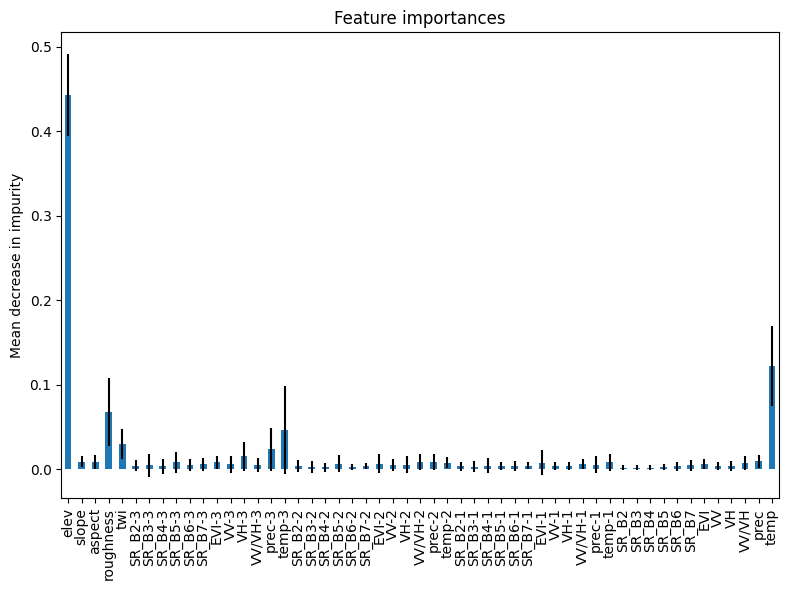

In [46]:
# Plot the feature importance
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=df.iloc[:,1:].columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [31]:
# SHapley Additive exPlanations
explainer = shap.TreeExplainer(model, np.array(Xtrain, dtype=float),)
shap_values = explainer(np.array(Xtest, dtype=float))

 99%|===================| 309/311 [00:48<00:00]        

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 7.240005, while the model output was 7.151666. If this difference is acceptable you can set check_additivity=False to disable this check.

 99%|===================| 309/311 [00:49<00:00]        

<BarContainer object of 17 artists>

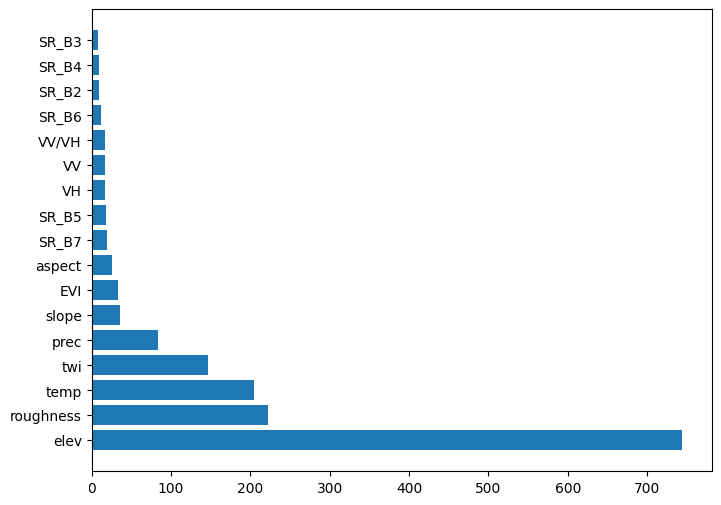

In [33]:
# SHapley Additive exPlanations
explainer = shap.TreeExplainer(model, np.array(Xtrain, dtype=float))
shap_values = explainer(np.array(Xtest, dtype=float), check_additivity=False)

shap_abs = np.absolute(shap_values.values)
sum = np.sum(shap_abs, axis=0)

averageshap = np.ones(17)
averageshap[:5] = sum[:5]
for i in range(5, 17):
    averageshap[i] = np.mean(sum[i::12])

variables = ['elev', 'slope', 'aspect', 'roughness', 'twi', 'SR_B2', 'SR_B3',
       'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'EVI', 'VV', 'VH', 'VV/VH', 'prec',
       'temp']

sorted_data = sorted(zip(averageshap, variables), reverse=True)
sorted_values, sorted_features = zip(*sorted_data)

plt.barh(sorted_features, sorted_values)

In [ ]:
# SHapley Additive exPlanations
explainer = shap.Explainer(model.predict, np.array(Xtest, dtype=float))
shap_values = explainer(np.array(Xtest, dtype=float))

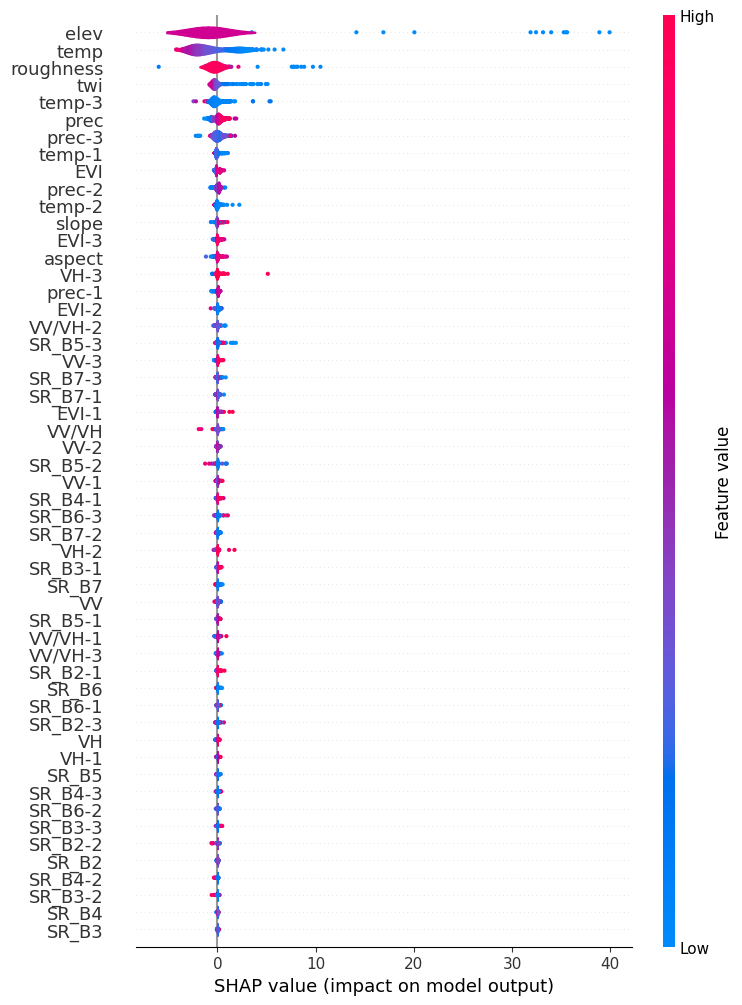

In [48]:
shap.plots.violin(shap_values, feature_names=list(Xtest.columns), max_display=len(Xtest.columns), plot_size=0.2)

In [49]:
# Save the model
joblib.dump(model, os.getcwd()+'/RF2y.pkl')

['/home/shoyo/Desktop/RF2y.pkl']

In [50]:
# Check if the model can be loaded properly
joblib.load('/home/shoyo/Desktop/RF2y.pkl')

RandomForestRegressor(min_samples_split=5, n_estimators=400, random_state=42)

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

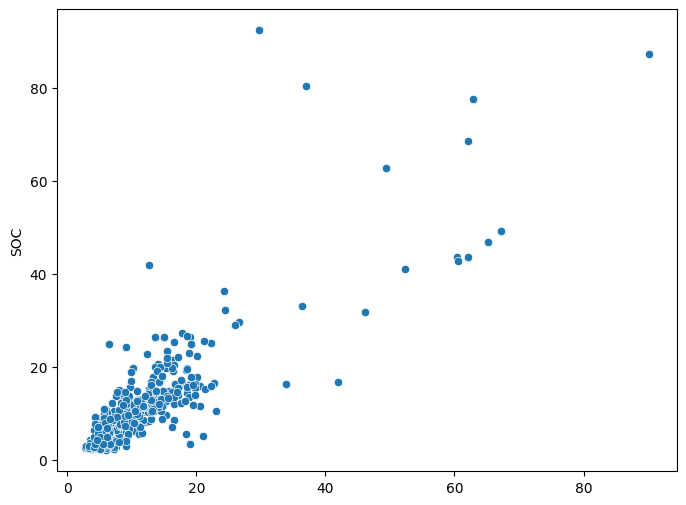

In [198]:
# Show a plot of the predicted SOC against the observed SOC
scatterplot=sns.scatterplot(x=np.squeeze(Ypred), y=np.squeeze(Ytest))
Ypred = pd.to_numeric(Ypred, errors='coerce')
Ytest = pd.to_numeric(Ytest, errors='coerce')
z = np.polyfit(Ypred, Ytest, 1)  #Least squares polynomial fit.
p = np.poly1d(z)                           #A one-dimensional polynomial class.
scatterplot.plot(np.squeeze(Ytest), p(np.squeeze(Ytest)), "r--", label='trend line')
# sns.lineplot(x=np.linspace(0, 80, 100), y=x, 'g', label='y=x')
plt.legend()
plt.xlabel("Predicted SOC")
plt.ylabel("Observed SOC")
plt.show()

ValueError: data type <class 'numpy.object_'> not inexact

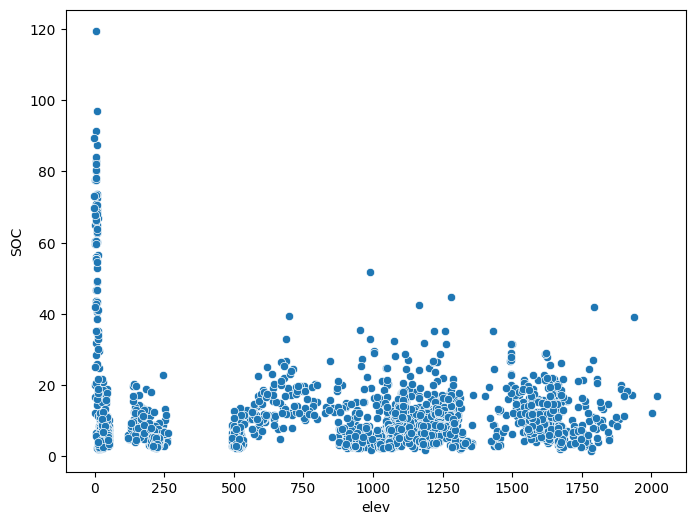

In [97]:
scatterplot=sns.scatterplot(x=df.elev, y=df.SOC)
# Ypred = pd.to_numeric(Ypred, errors='coerce')
# Ytest = pd.to_numeric(Ytest, errors='coerce')
z = np.polyfit(df.elev, df.SOC, 1)  #Least squares polynomial fit.
p = np.poly1d(z)                           #A one-dimensional polynomial class.
scatterplot.plot(df.SOC, p(df.SOC), "r--", label='trend line')
# sns.lineplot(x=np.linspace(0, 80, 100), y=x, 'g', label='y=x')
plt.legend()
plt.xlabel("Predicted SOC")
plt.ylabel("Observed SOC")
plt.show()

In [ ]:
# Create a new column with shuffled regions
shuffled_regions = np.random.permutation(df['region'])
df['shuffled_region'] = shuffled_regions

# Sort the DataFrame based on the shuffled regions
df_sorted = df.sort_values('shuffled_region')

# Drop the 'shuffled_region' column if not needed
df_sorted.drop('shuffled_region', axis=1, inplace=True)